In [1]:
import os
import torch
from tqdm import tqdm
#from ffcv.fields import BytesField, IntField, RGBImageField
#from ffcv.writer import DatasetWriter

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Variable

from data_utils.data_stats import *
#from data_utils.dataloader import get_loader
from utils.metrics import topk_acc, real_acc, AverageMeter
from models.networks import *
#from data_utils.dataset_to_beton import get_dataset


from utils.download import *

In [2]:
"""
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
"""

"\ndataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21\narchitecture = 'B_12-Wi_1024'\ndata_resolution = 32                # Resolution of data as it is stored\ncrop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)\nnum_classes = CLASS_DICT[dataset]\ndata_path = './beton/'\neval_batch_size = 1024\ncheckpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10\n"

In [135]:
dataset = 'imagenet'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024' #'B_6-Wi_512'         #'B_12-Wi_1024'  'B-12_Wi-1024_res_64_imagenet_epochs_50'   
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_imagenet'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [136]:

# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint=checkpoint)



Weights already downloaded
Load_state output <All keys matched successfully>


### Visualize the weights of the input layer

In [137]:
state_dict = model.state_dict()
state_dict.keys()


odict_keys(['linear_in.weight', 'linear_in.bias', 'linear_out.weight', 'linear_out.bias', 'blocks.0.block.0.weight', 'blocks.0.block.0.bias', 'blocks.0.block.2.weight', 'blocks.0.block.2.bias', 'blocks.1.block.0.weight', 'blocks.1.block.0.bias', 'blocks.1.block.2.weight', 'blocks.1.block.2.bias', 'blocks.2.block.0.weight', 'blocks.2.block.0.bias', 'blocks.2.block.2.weight', 'blocks.2.block.2.bias', 'blocks.3.block.0.weight', 'blocks.3.block.0.bias', 'blocks.3.block.2.weight', 'blocks.3.block.2.bias', 'blocks.4.block.0.weight', 'blocks.4.block.0.bias', 'blocks.4.block.2.weight', 'blocks.4.block.2.bias', 'blocks.5.block.0.weight', 'blocks.5.block.0.bias', 'blocks.5.block.2.weight', 'blocks.5.block.2.bias', 'blocks.6.block.0.weight', 'blocks.6.block.0.bias', 'blocks.6.block.2.weight', 'blocks.6.block.2.bias', 'blocks.7.block.0.weight', 'blocks.7.block.0.bias', 'blocks.7.block.2.weight', 'blocks.7.block.2.bias', 'blocks.8.block.0.weight', 'blocks.8.block.0.bias', 'blocks.8.block.2.weight',

In [140]:
layer_name = 'linear_in.weight' #'linear_out.weight' #
weights = state_dict[layer_name]
print(weights.size())
print(f"Weights of {layer_name}:\n{weights}")


torch.Size([1024, 12288])
Weights of linear_in.weight:
tensor([[ 2.2785e-01,  2.9513e-01,  3.1012e-03,  ..., -1.0594e-01,
          2.2147e-02,  8.5203e-02],
        [-2.3599e-01, -5.2422e-02, -4.1217e-02,  ..., -1.1177e-01,
         -4.4740e-01, -4.3109e-01],
        [-4.5495e-01, -4.4787e-01, -2.9203e-01,  ...,  1.4033e-01,
          2.5422e-01,  3.6087e-01],
        ...,
        [ 1.7607e-02, -3.5418e-01,  1.9371e-02,  ..., -2.6691e-01,
         -5.2200e-01, -2.3111e-01],
        [ 3.8978e-01,  1.9745e-01,  4.5564e-01,  ...,  2.0694e-01,
          4.6923e-01,  3.8922e-01],
        [-1.0741e-02,  2.3873e-05,  6.7596e-02,  ..., -3.2074e-02,
         -1.3536e-02, -9.1601e-02]])


In [141]:
# Reshape layer weights to (w*h*3*m)
w_in = int(np.sqrt(weights.size()[1]/3))
h_in = int(np.sqrt(weights.size()[1]/3))
m_out = weights.size()[0]
print(w_in)
print(h_in)
print(m_out)

weights_reshaped = torch.reshape(weights, (w_in, h_in, 3, m_out))
print(weights.size())
print(weights_reshaped.size())

64
64
1024
torch.Size([1024, 12288])
torch.Size([64, 64, 3, 1024])


In [142]:
# Take max value along the channel dimension
weights_arr_max = np.max(weights_reshaped.numpy(), axis=2)
weights_arr_max.shape

(64, 64, 1024)

0
0.3737890005111694


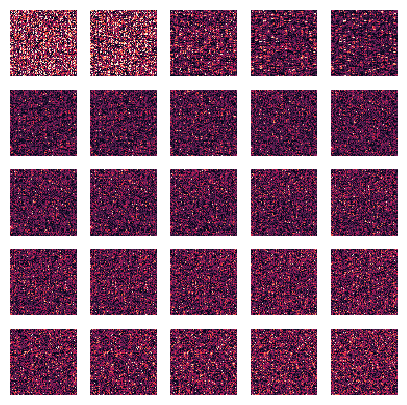

In [175]:
# Plot heatmap 
n_x = 5
n_y = 5
fig, ax = plt.subplots(n_y, n_x)
fig.set_figwidth(5)
fig.set_figheight(5)

offset = 0
cb_min = 0#0.4*np.min(weights_arr_max)
cb_max = 0.3*np.max(weights_arr_max)
print(cb_min)
print(cb_max)

for i in range(n_x):
    for j in range(n_y):
        plt_idx = j*n_y + (i+1)
        weight_idx = plt_idx -1 + offset
        #print(plt_idx)
        #print(weight_idx)
        plt.subplot(n_x, n_y, plt_idx)
        ax[j,i] = sns.heatmap(weights_arr_max[:,:,weight_idx], cbar=False, xticklabels=False, yticklabels=False, vmin=cb_min, vmax=cb_max)#cmap="Greys_r")

plt.show()



### Visualize input with max activations
Source of original code: https://deepnote.com/workspace/first-deepnote-workspace-6bdc-36bc3217-197c-4b31-af13-4c932926817f/project/DataScience-03e6a746-b7e8-4b20-84cb-0bec0366adab/notebook/CS231n%2Fassignment3%2FNetworkVisualization-PyTorch-d66d16083d1044b6bf08de99fc61779f?

In [144]:
model

BottleneckMLP(
  (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
  (linear_out): Linear(in_features=1024, out_features=1000, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=4096, out_features=1024, bias=True)
      )
    )
  )
  (layernorms): ModuleList(
    (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
)

In [145]:
type(model)

models.networks.BottleneckMLP

In [146]:
import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import random

import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
#from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [147]:



# Standardization statistics
MEAN_DICT = {
    "imagenet21": np.array([0.485, 0.456, 0.406]) * 255,
    "imagenet": np.array([0.485, 0.456, 0.406]) * 255,
    "imagenet_real": np.array([0.485, 0.456, 0.406]) * 255,
    "tinyimagenet": np.array([0.485, 0.456, 0.406]) * 255,
    "cifar10": np.array([0.49139968, 0.48215827, 0.44653124]) * 255,
    "cifar100": np.array([0.49139968, 0.48215827, 0.44653124]) * 255,
    "stl10": np.array([0.4914, 0.4822, 0.4465]) * 255,
}


STD_DICT = {
    "imagenet21": np.array([0.229, 0.224, 0.225]) * 255,
    "imagenet": np.array([0.229, 0.224, 0.225]) * 255,
    "imagenet_real": np.array([0.229, 0.224, 0.225]) * 255,
    "tinyimagenet": np.array([0.229, 0.224, 0.225]) * 255,
    "cifar10": np.array([0.24703233, 0.24348505, 0.26158768]) * 255,
    "cifar100": np.array([0.24703233, 0.24348505, 0.26158768]) * 255,
    "stl10": np.array([0.2471, 0.2435, 0.2616]) * 255,
}

In [149]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)


def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [150]:
if False:
    # Download and load the pretrained SqueezeNet model.
    model = torchvision.models.squeezenet1_1(pretrained=True)

    # We don't want to train the model, so tell PyTorch not to compute gradients
    # with respect to model parameters.
    for param in model.parameters():
        param.requires_grad = False

In [151]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    #print(X.size())

    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [153]:
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)

In [169]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 200) #100
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.    
    img = torch.randn(1, 3, crop_resolution, crop_resolution).mul_(1.0).type(dtype)
    img_reshaped = torch.reshape(img, (img.shape[0], -1))
    img_var = Variable(img_reshaped, requires_grad=True)
    original_shape = (img.shape[0], img.shape[1], crop_resolution, crop_resolution)
    img_restored = img_reshaped.view(original_shape)


    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img_restored.copy_(jitter(img_restored, ox, oy))
        img_reshaped = torch.reshape(img_restored, (img_restored.shape[0], -1))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        scores = model(img_var)
        scores[:, target_y].backward()
        
        grad = img_var.grad.data - 2 * l2_reg * img_reshaped
        img_reshaped += learning_rate * grad
        img_restored = img_reshaped.view(original_shape)
        
        img_var.grad.data.zero_()

        

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        # Undo the random jitter
        img_restored.copy_(jitter(img_restored, -ox, -oy))
        img_reshaped = torch.reshape(img_restored, (img_restored.shape[0], -1))



        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img_restored[:, c].clamp_(min=lo, max=hi)
            img_reshaped = torch.reshape(img_restored, (img_restored.shape[0], -1))

        if t % blur_every == 0:
            #blur_image(img, sigma=0.5)
            img_restored = blur_image(img_restored, sigma=0.5)
            img_reshaped = torch.reshape(img_restored, (img_restored.shape[0], -1))
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img_restored.clone().cpu()))
            #class_name = class_names[target_y]
            #plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.title('Iteration %d / %d' % (t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img_restored.cpu())

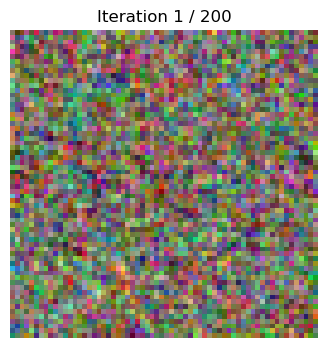

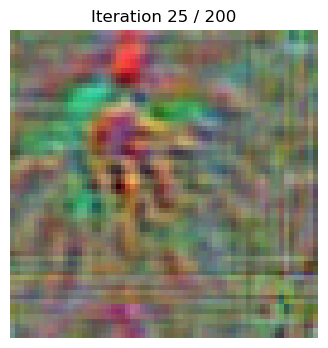

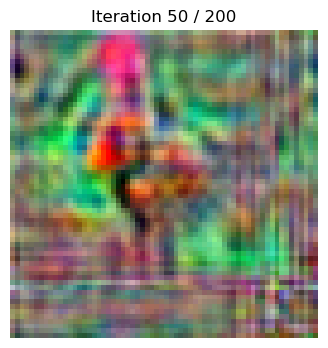

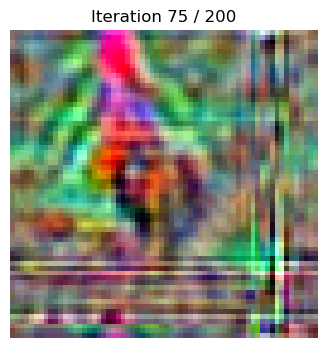

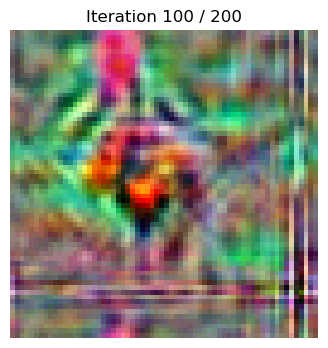

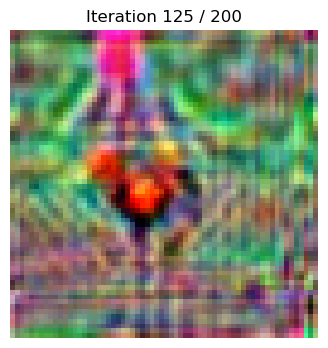

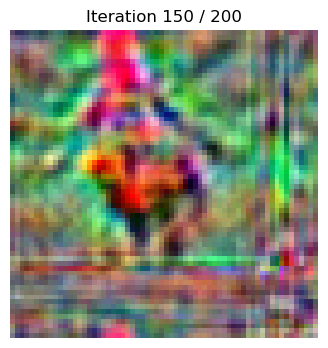

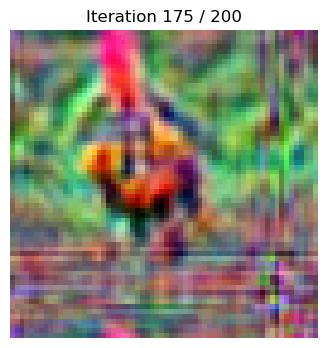

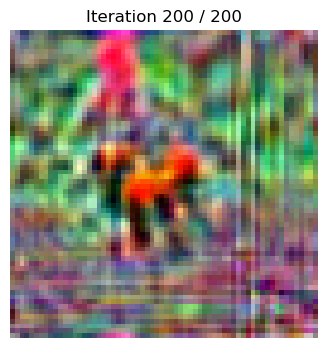

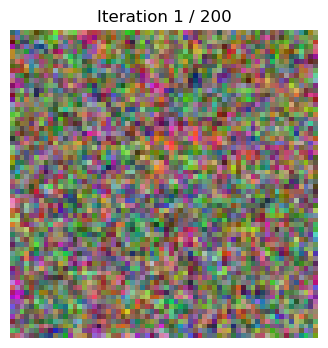

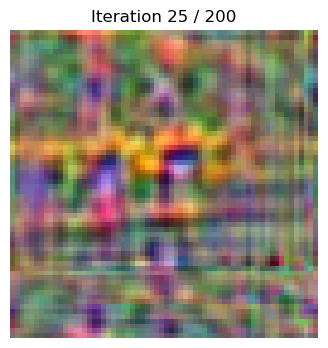

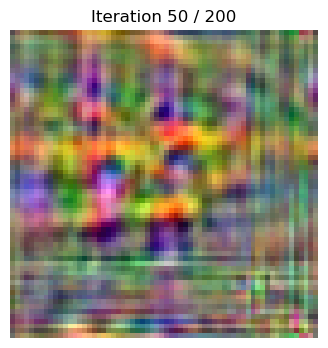

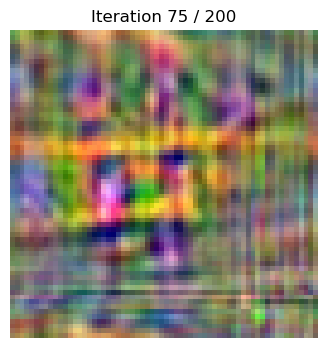

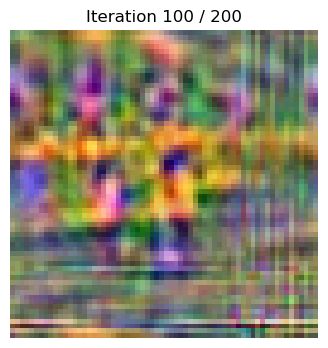

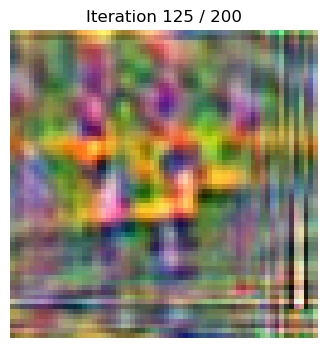

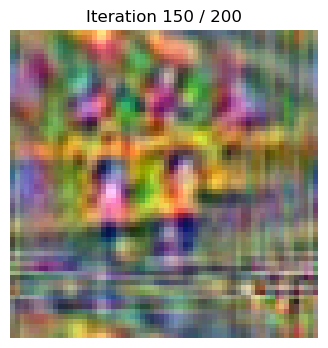

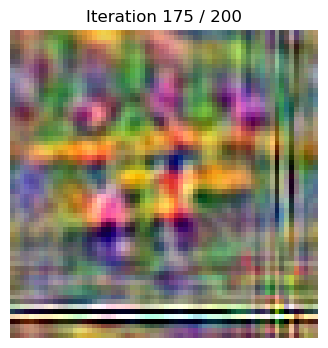

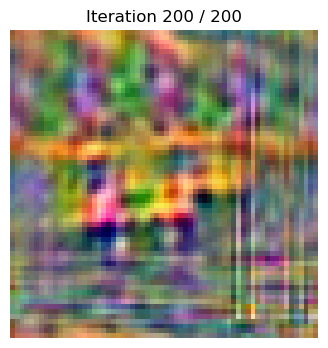

In [170]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 7 # Hen
target_y2 = 779 # School bus
# target_y = 76 # Tarantula
# target_y = 78 # Tick
#target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)

out = create_class_visualization(target_y2, model, dtype)


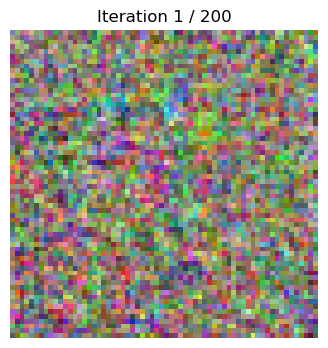

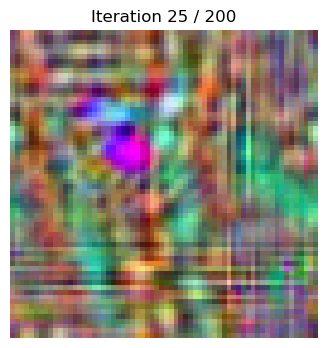

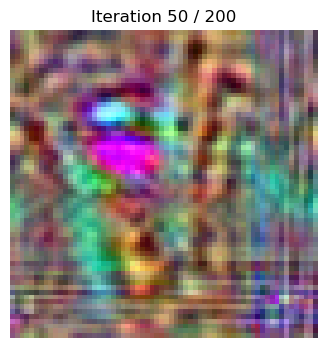

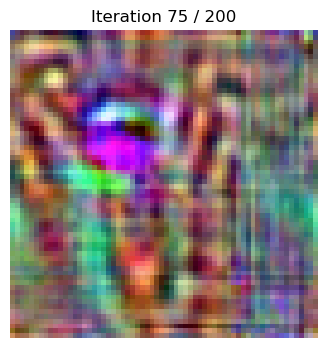

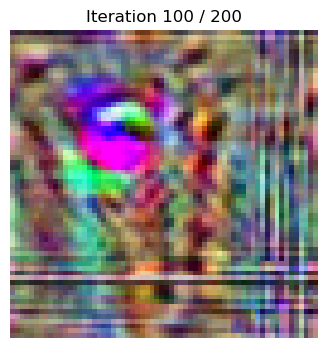

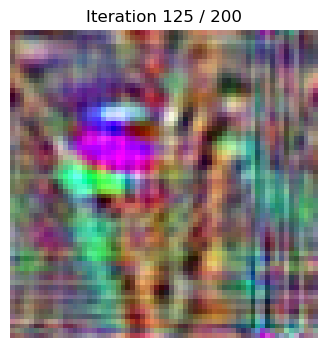

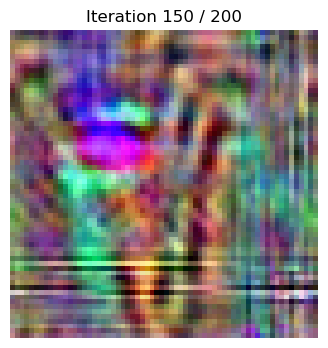

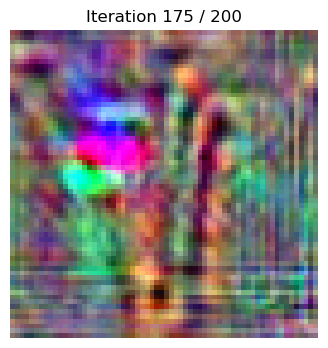

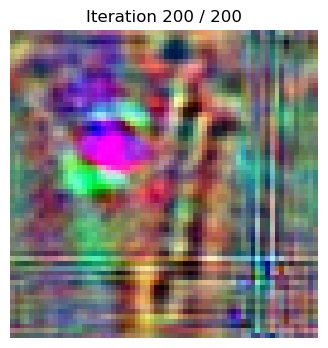

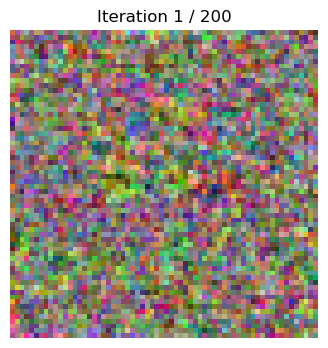

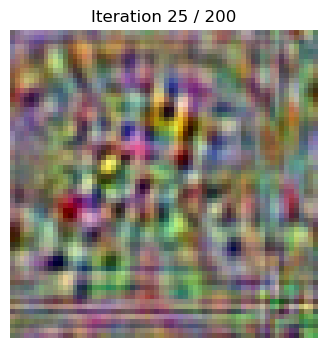

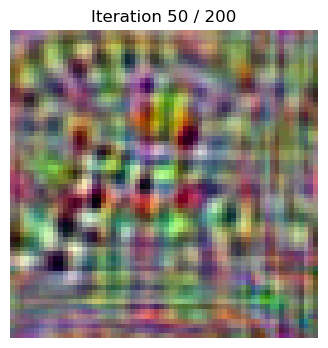

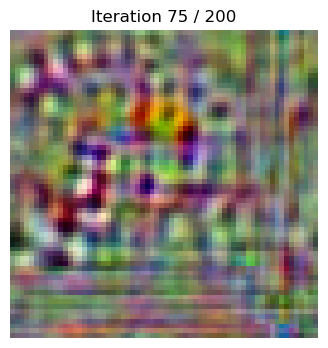

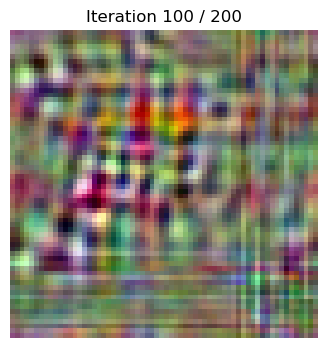

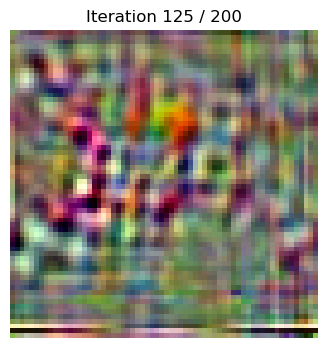

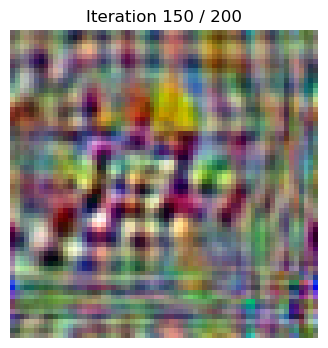

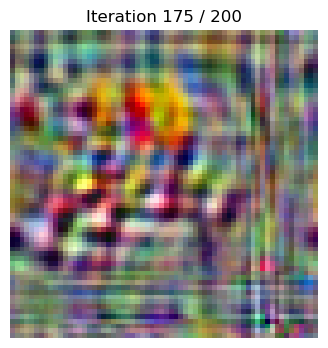

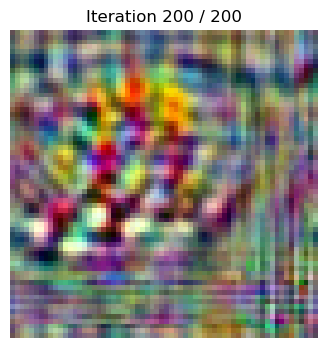

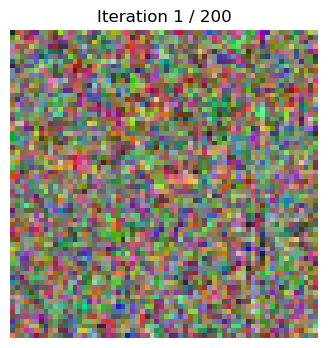

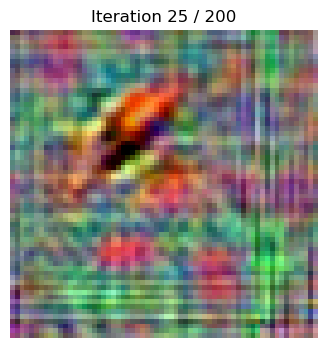

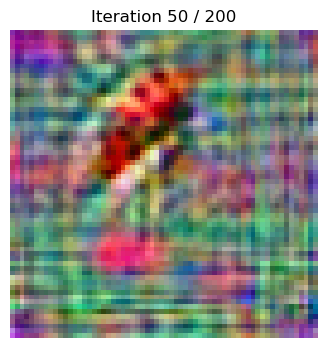

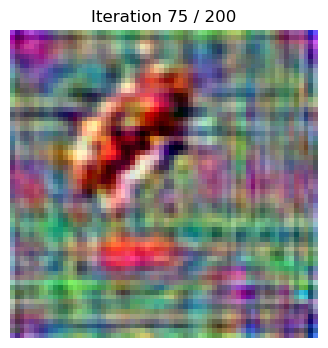

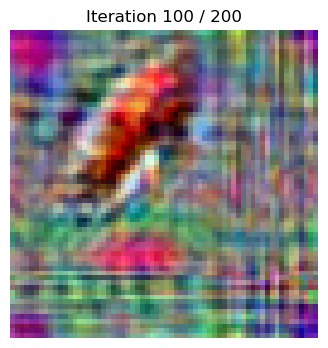

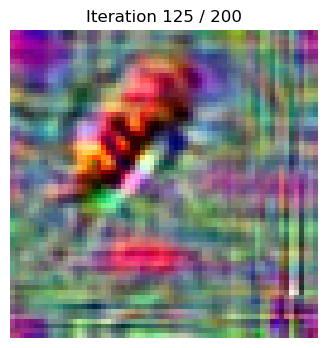

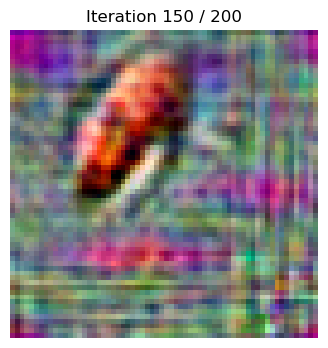

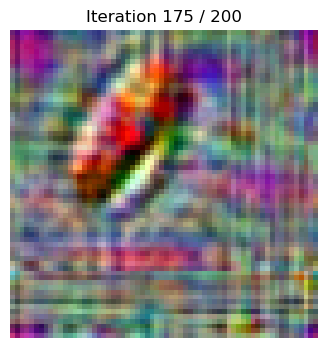

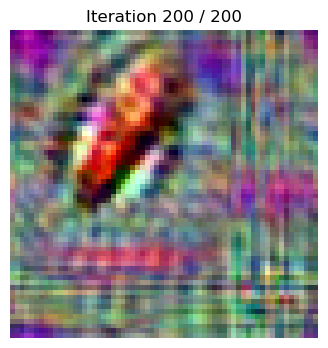

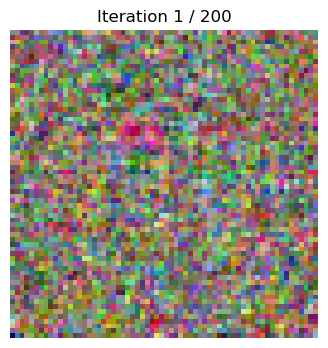

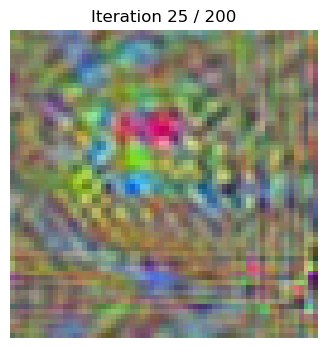

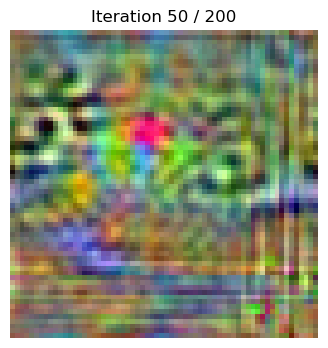

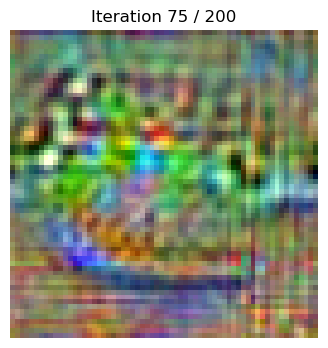

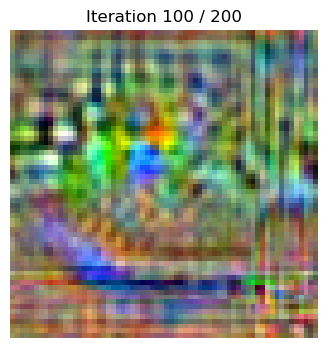

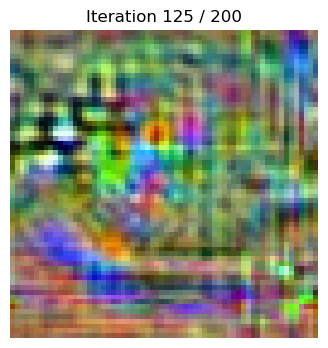

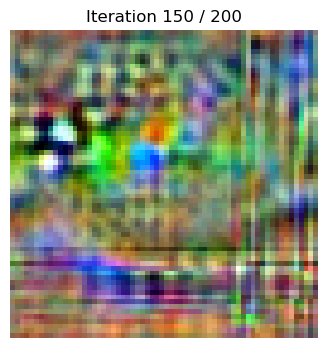

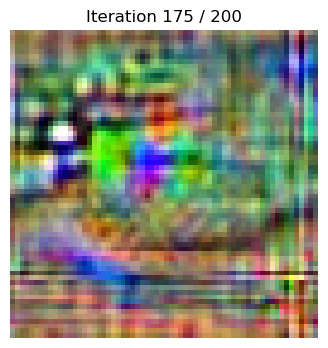

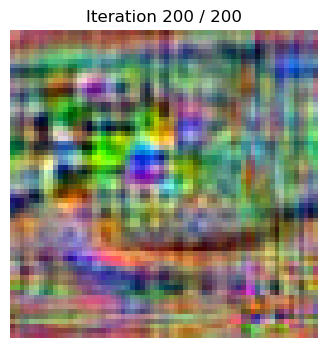

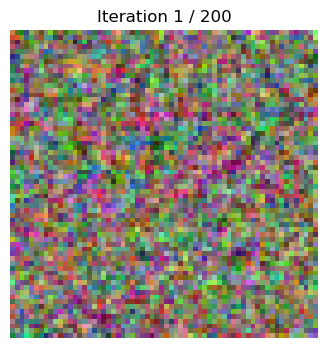

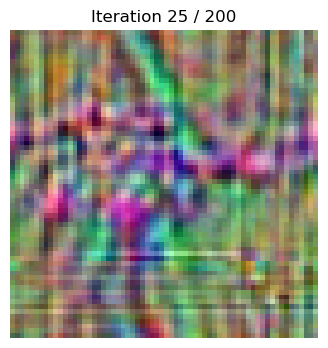

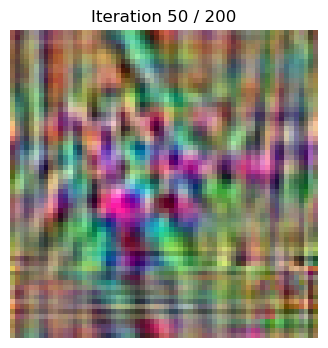

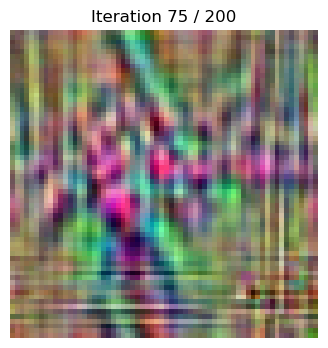

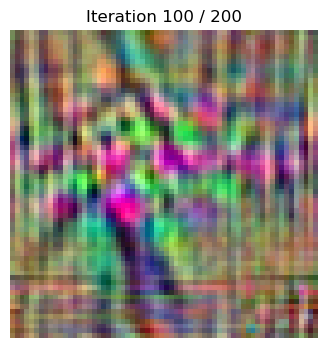

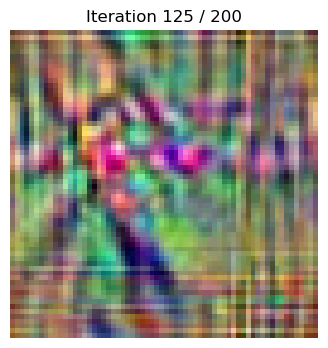

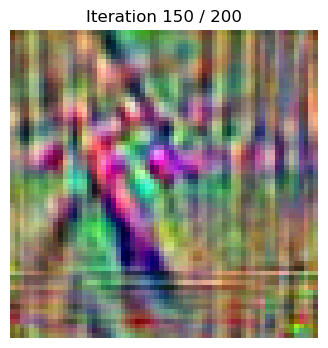

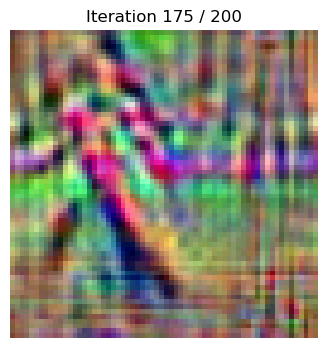

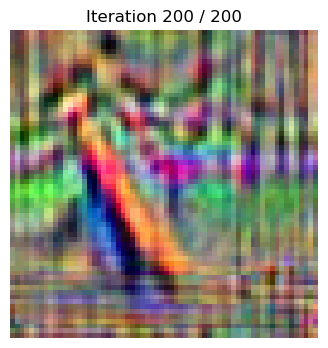

In [171]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 776 # Sax
target_y2 = 861 # Toilet seat
target_y3 = 314 # cockroach
target_y4 = 6 # stingray
target_y5 = 594 # harp

# target_y = 76 # Tarantula
# target_y = 78 # Tick
#target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)
out = create_class_visualization(target_y2, model, dtype)
out = create_class_visualization(target_y3, model, dtype)
out = create_class_visualization(target_y4, model, dtype)
out = create_class_visualization(target_y5, model, dtype)


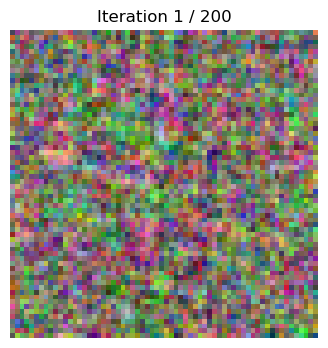

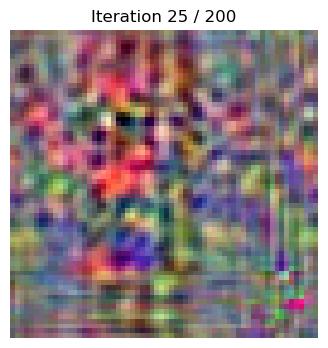

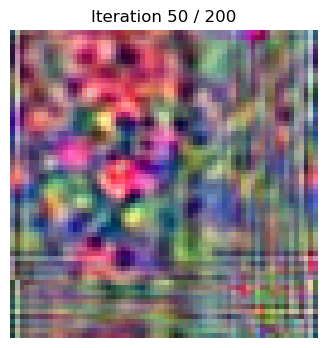

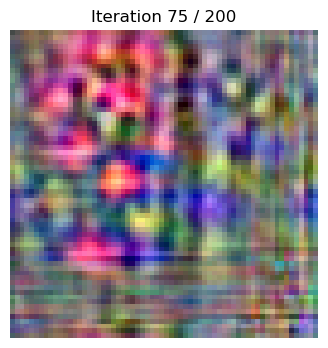

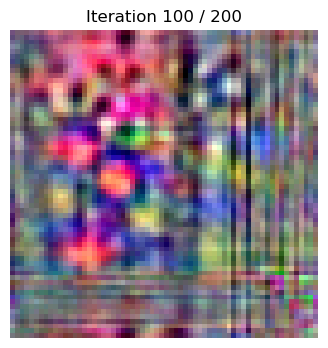

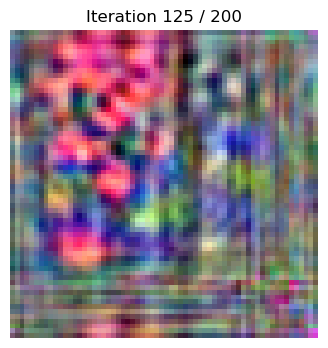

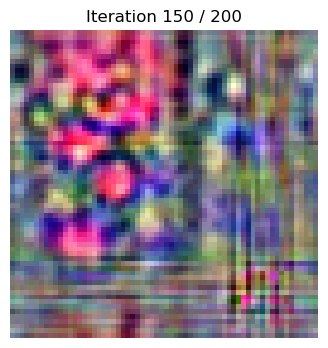

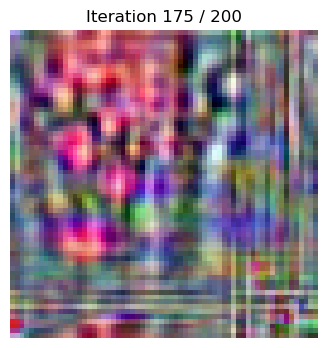

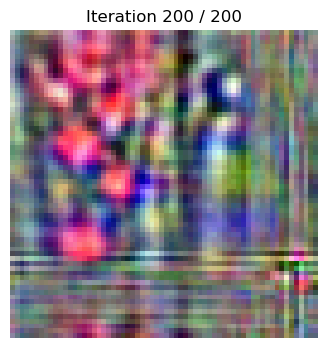

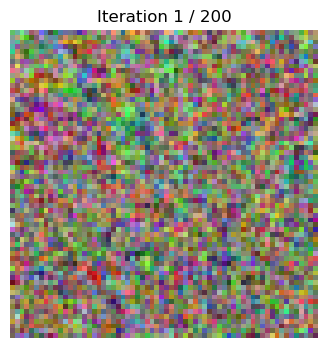

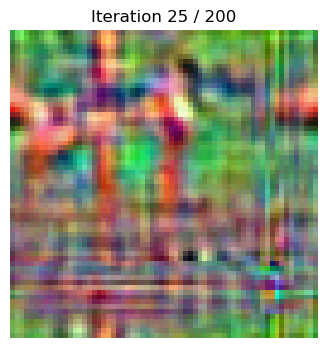

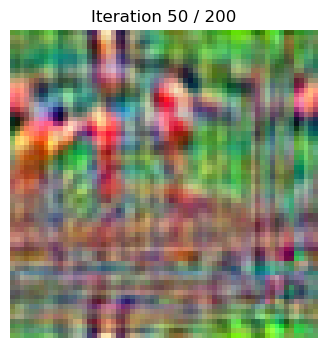

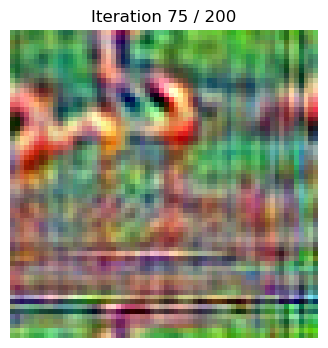

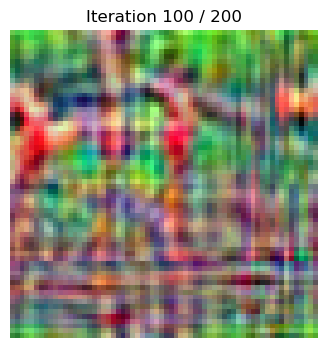

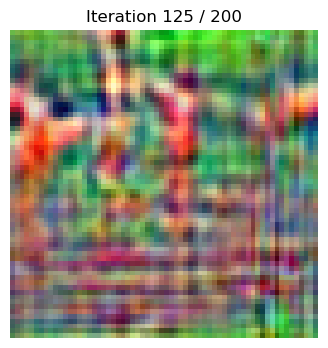

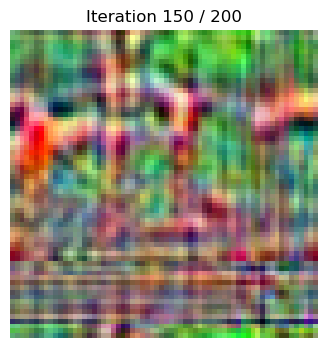

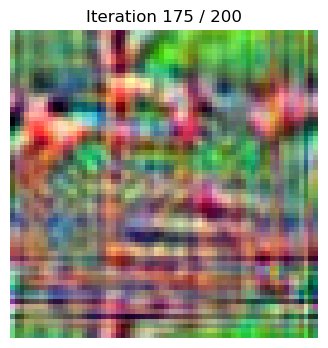

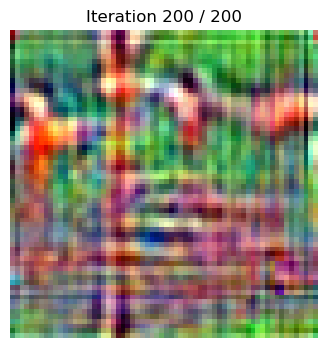

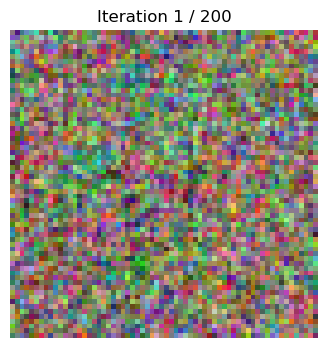

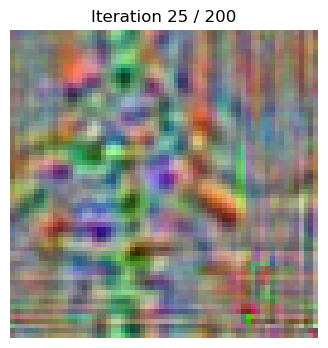

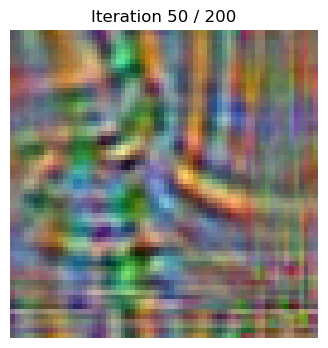

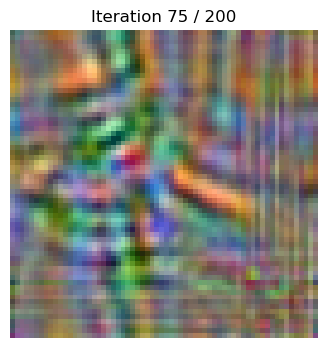

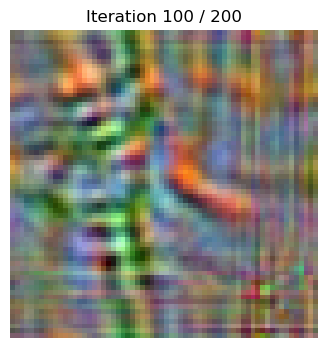

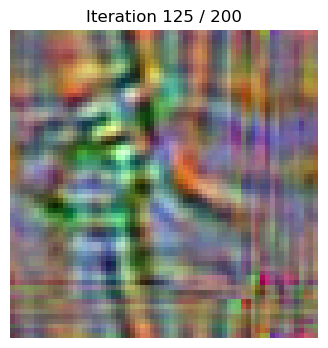

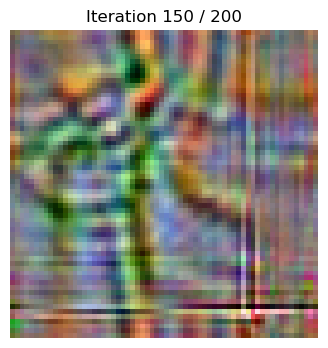

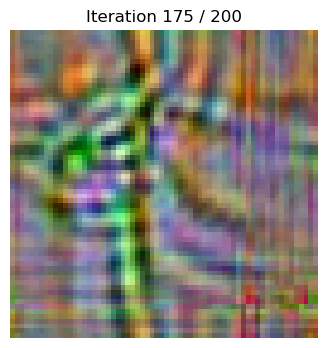

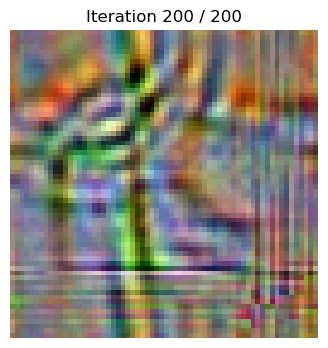

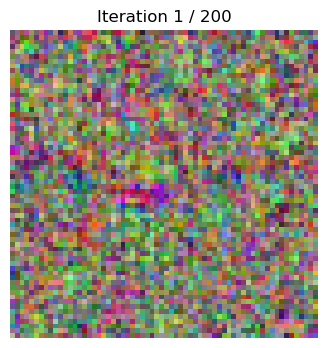

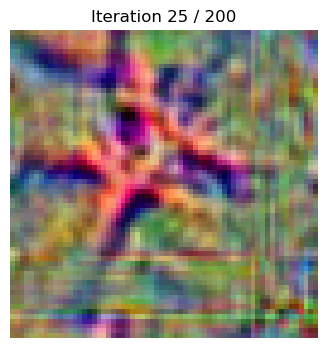

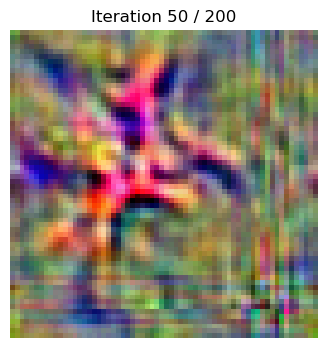

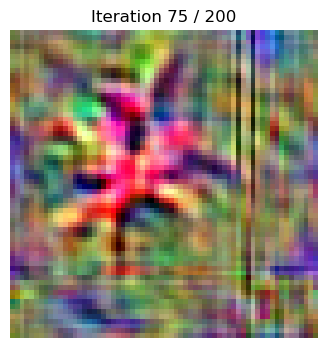

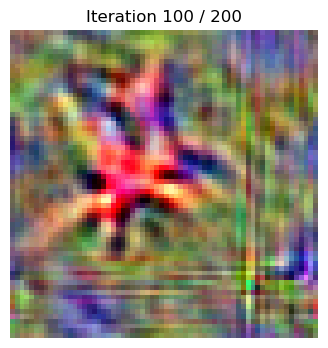

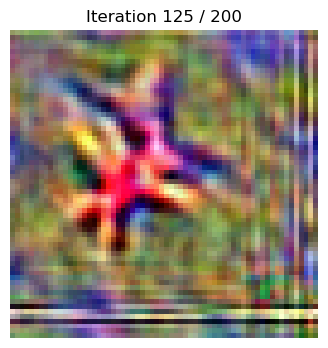

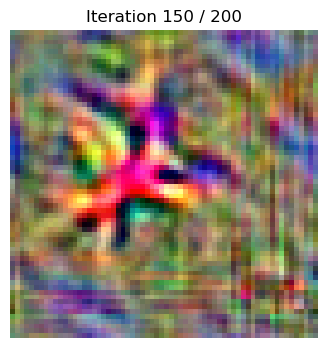

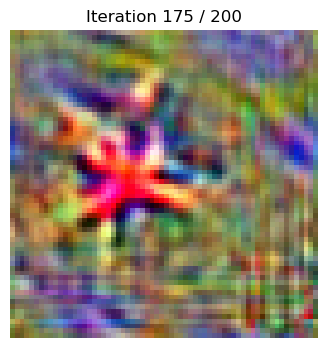

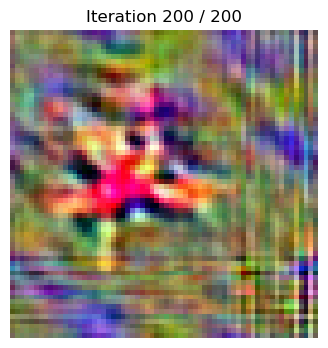

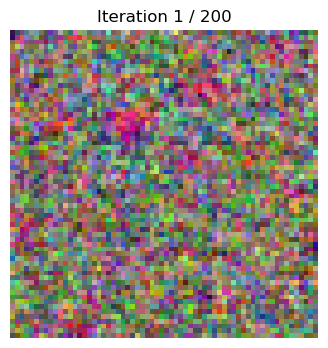

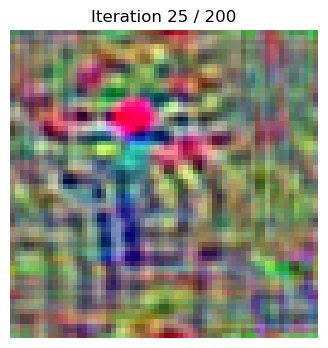

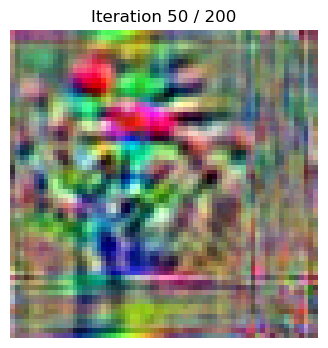

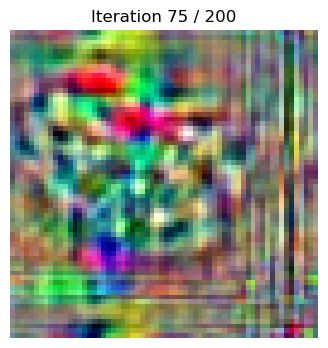

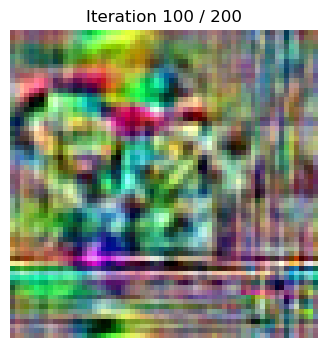

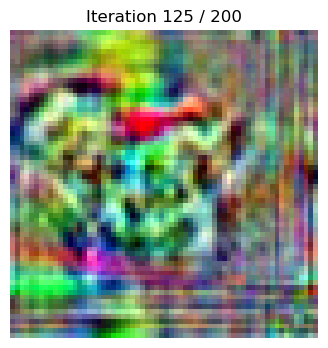

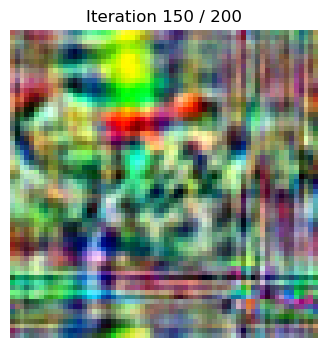

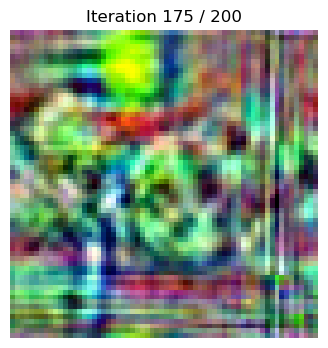

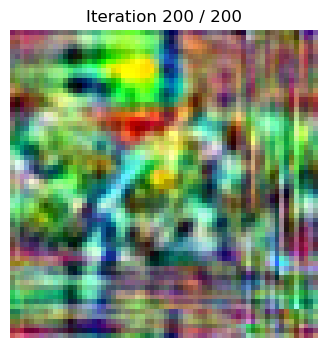

In [172]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

target_y = 503 # cocktail shaker
target_y2 = 130 # flamingo
target_y3 = 150 # sea lion
target_y4 = 327 # starfish
target_y5 = 430 # Basketball

# target_y = 76 # Tarantula
# target_y = 78 # Tick
#target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)
out = create_class_visualization(target_y2, model, dtype)
out = create_class_visualization(target_y3, model, dtype)
out = create_class_visualization(target_y4, model, dtype)
out = create_class_visualization(target_y5, model, dtype)